In [2]:
# compose annotation files
from pathlib import Path
import json

in_path = Path('/home/aiteam/tykim/nia-3d/indoor')
out_path = Path('/home/aiteam/tykim/nia-3d/outdoor')
# 156개
json_list = list(in_path.glob('*.json')) + list(out_path.glob('*.json'))

In [3]:
annos = {"annotations": []}

for anno_json in json_list:  
  with open(anno_json) as f:
    nia_anno = json.load(f)

  if 'meta' in nia_anno:
    nia_anno_meta = nia_anno['meta']
  else:
    nia_anno_meta = nia_anno
      
  tmp = {}
  human_ann = {}
  # list of dict를 nested 
  for anno_dict in nia_anno['objects']:
    for k, v in anno_dict.items():
      human_ann[k] = v

  newlist = []
  for key_anno in human_ann['annotation.human.keypoint.2d']:
      newlist.append(key_anno)
      
  kp_list = []
  for kp in newlist:
    kp_list.append(kp['x'])
    kp_list.append(kp['y'])
    kp_list.append(int(kp['state']['visible']))
      

  bbox_list = []
  for k,v in human_ann['annotation.human.bbox.2d'].items():
    bbox_list.append(v)
    
  # tmp['bbox'] = human_ann['annotation.human.bbox.2d'] 
  tmp['keypoints'] = kp_list
  tmp['bbox'] = bbox_list

  tmp['image'] = nia_anno["info.image.id"]
  name, ext = nia_anno["info.image.id"].split('.')
  tmp['image'] = name + '.' +  ext.lower()
  tmp['width'] = nia_anno_meta["info.image.width"] # weight
  tmp['height'] = nia_anno_meta["info.image.height"] # height
  tmp['f'] = nia_anno_meta["info.camera.focal_length"] # f
  tmp['c'] = nia_anno_meta["info.camera.principal_point"] # c
  annos['annotations'].append(tmp)


In [7]:
len(annos['annotations'][0]['keypoints'])

87

In [8]:

import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import multiprocessing
import json
from PIL import Image
import os

'''
FIXED PARAMETERS
'''

#DIMENSIONS OF RESIZED IMAGE (INPUT FOR THE MODEL)
IMG_WIDTH = 192
IMG_HEIGHT = 256

#PARAMETERS OF THE KEYPOINTS OF THE DATASET
N_DIM = 3 #x,y,visibility
# N_KEYPOINTS = 17 #it is set later in the code just in case
# K_NAMES = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'] #it is set later in the code just in case


K_NAMES = ['pelvis',
 'left hip',
 'left knee',
 'left ankle',
 'left bigtoe',
 'left littletoe',
 'right hip',
 'right_knee',
 'right ankle',
 'right bigtoe',
 'right littletoe',
 'waist',
 'chest',
 'neck',
 'left shoulder',
 'left elbow',
 'left wrist',
 'left index finger',
 'left pinky',
 'right shoulder',
 'right elbow',
 'right wrist',
 'right index finger',
 'right pinky',
 'nose',
 'left eye',
 'left ear',
 'right eye',
 'right ear']

N_KEYPOINTS = 29


def plot_keypoints(draw_non_visible,keypoints,k_vis,ax): #draw_non_visible -> option to draw (1) or not (0) keypoints that are in the dataset but not visible in the image (occlusions)
    for j in range(len(K_NAMES)):
        n = K_NAMES[j]
        x = keypoints[j,0]
        y = keypoints[j,1]

        if k_vis[j] > 0 and (draw_non_visible or (draw_non_visible == 0 and k_vis[j] == 2)):
          ax.scatter(x, y, 250)
          ax.text(x+5, y+5, n, fontsize=18, bbox=dict(facecolor='r', alpha=0.5), color='w')
          
def display_images_keypoints(draw_non_visible,og_img,bbox,res_img,keypoints,k_vis):
    #display original image with bounding box and resized image with keypoints
    bbox_x,bbox_y,bbox_w,bbox_h = bbox
    fig = plt.figure(1,figsize=(20,20))
    ax1 = fig.add_subplot(121)  # left side
    ax1.imshow(og_img)
    ax1.add_patch(Rectangle((bbox_x, bbox_y), bbox_w, bbox_h, alpha=0.3, facecolor="blue", edgecolor="red", hatch='x'))

    ax2 = fig.add_subplot(122)  # right side
    ax2.imshow(res_img)
    ax2 = plot_keypoints(draw_non_visible,keypoints,k_vis,ax2)
    plt.show()

In [9]:
def check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img):
    #attributes of the bounding box and original image
    bbox_x, bbox_y, bbox_w, bbox_h = bbox
    img_w, img_h = og_img.size
    
    #calculate min and max values of x and y positions of the keypoints
    x_min = 99999
    x_max = -1
    y_min = 99999
    y_max = -1
    for i in range(len(keypoints)):
        if k_vis[i] > 0:
            x_temp = keypoints[i][0]
            y_temp = keypoints[i][1]
            if x_temp < x_min: x_min = x_temp
            if x_temp > x_max: x_max = x_temp
            if y_temp < y_min: y_min = y_temp
            if y_temp > y_max: y_max = y_temp
    x_min = x_min-10
    x_max = x_max+10
    y_min = y_min-10
    y_max = y_max+10
        
    if x_min < bbox_x:
        if x_min < 0: x_min = 0
    else:
        x_min = bbox_x
    
    if x_max > bbox_x+bbox_w:
        if x_max > img_w: x_max = img_w
    else:
        x_max = bbox_x+bbox_w
        
    if y_min < bbox_y:
        if y_min < 0: y_min = 0
    else:
        y_min = bbox_y
        
    if y_max > bbox_y+bbox_h:
        if y_max > img_h: y_max = img_h
    else:
        y_max = bbox_y+bbox_h
        
    bbox = [x_min,y_min,x_max-x_min,y_max-y_min]
    return bbox
    

In [13]:
annos.keys()

dict_keys(['annotations'])

In [3]:
import json
with open('/home/aiteam/tykim/nia-3d/HybrIK/data/nia/annotations/nia_ann.json') as f:
  ann = json.load(f)

In [4]:
ann['annotations'][0].keys()

dict_keys(['keypoints', 'bbox', 'image', 'width', 'height', 'f', 'c'])

In [14]:
def get_sample_att(sample_n): #torval -> 0 if training and 1 if validation dataset
    # sample = ann['annotations'][sample_n]
    sample = annos['annotations'][sample_n]
    img_id = str(sample['image'])
    k_list = sample['keypoints']
    bbox = sample['bbox']
    # is_crowd = sample['iscrowd']

    #the keypoints in each sample are indicated in a list as: x1, y1, v1, x2, y2, v2, x3... and there are 
    #17 keypoints, so, we need it in a bidimensional array of 17x3

    k_array = np.asarray(k_list)
    k_array3d = np.reshape(k_array,(N_KEYPOINTS,N_DIM))
    keypoints = k_array3d[:,:2]
    k_vis = k_array3d[:,2]
    
    return img_id,bbox,keypoints,k_vis

In [15]:
def get_img(img_id):
    #load image
    #the image names are 12 digits and the first gaps are filled with 0's
    img_path = os.path.join('/home/aiteam/tykim/nia-3d/HybrIK/data/nia/imgs2', img_id)
    og_img = Image.open(img_path)
    return og_img

# get_img('36')

In [16]:
def crop_resize_img(og_img,bbox): #torval -> 0 if training and 1 if validation dataset
    #attributes of the bounding box
    bbox_x, bbox_y, bbox_w, bbox_h = bbox
    
    #resize image part of the bounding box
    res_img = og_img.resize((IMG_WIDTH, IMG_HEIGHT), box=(bbox_x,bbox_y,bbox_x+bbox_w,bbox_y+bbox_h))
    
    return res_img

In [17]:
def rescale_keypoints(keypoints,bbox):
    bbox_x,bbox_y,bbox_w,bbox_h = bbox
    box_start_pos = np.asarray([bbox_x,bbox_y])
    box_size = np.asarray([bbox_w,bbox_h])
    res_size = np.asarray([IMG_WIDTH,IMG_HEIGHT])
    keypoints = np.round((keypoints-box_start_pos)*(res_size/box_size)).astype(int)

    keypoints[keypoints<0] = 0 #if the original value was 0, then it will be converted to negative, so it should be reconverted to 0
    
    return keypoints

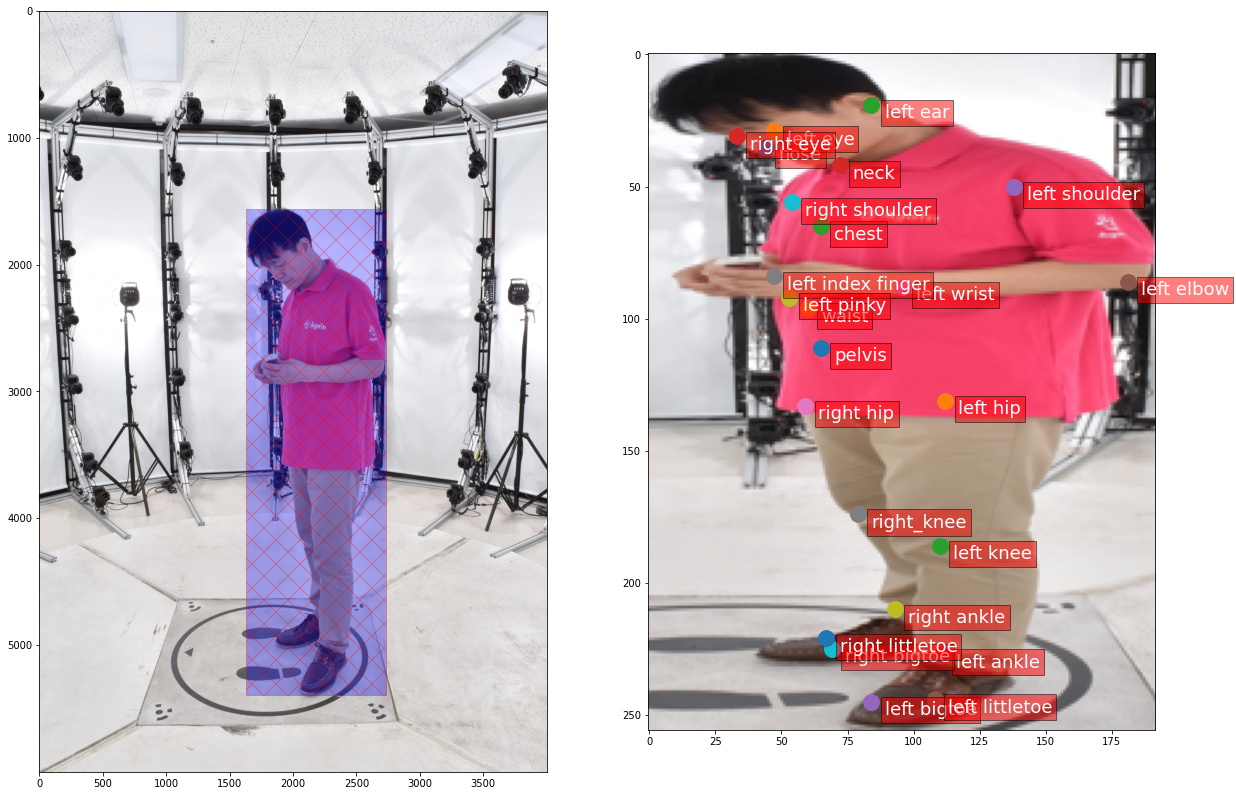

In [18]:
img_id,bbox,keypoints,k_vis = get_sample_att(0)
og_img = get_img(img_id)
bbox = check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img)
res_img = crop_resize_img(og_img,bbox)
keypoints = rescale_keypoints(keypoints,bbox)
display_images_keypoints(1,og_img,bbox,res_img,keypoints,k_vis)

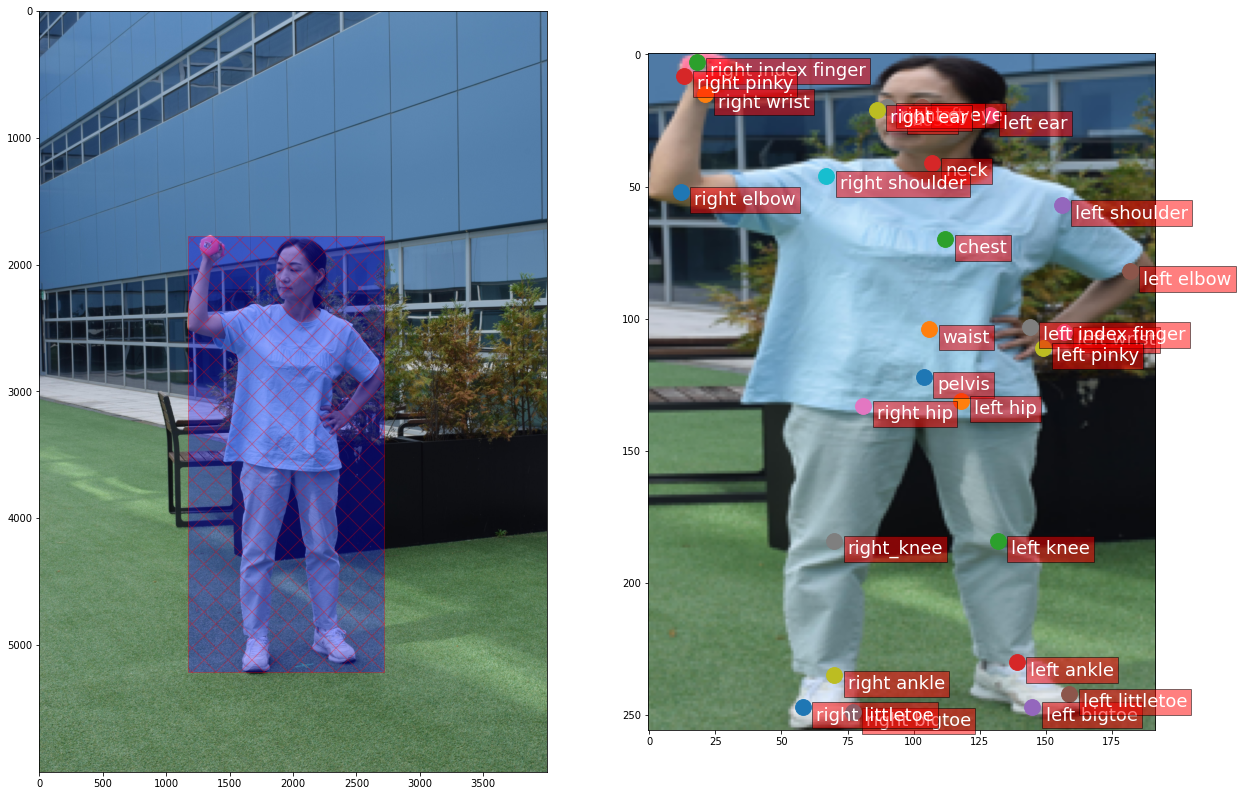

In [35]:
img_id,bbox,keypoints,k_vis = get_sample_att(100)
k_vis = [1] * 29
og_img = get_img(img_id)
bbox = check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img)
res_img = crop_resize_img(og_img,bbox)
keypoints = rescale_keypoints(keypoints,bbox)
display_images_keypoints(1,og_img,bbox,res_img,keypoints,k_vis)

In [26]:
len(keypoints)

29

In [27]:
img_id

'E_F054_T079-T01-00_T000-T00-00_B00099_L.jpg'

In [34]:
k_vis = [1] * 29

In [33]:
t

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

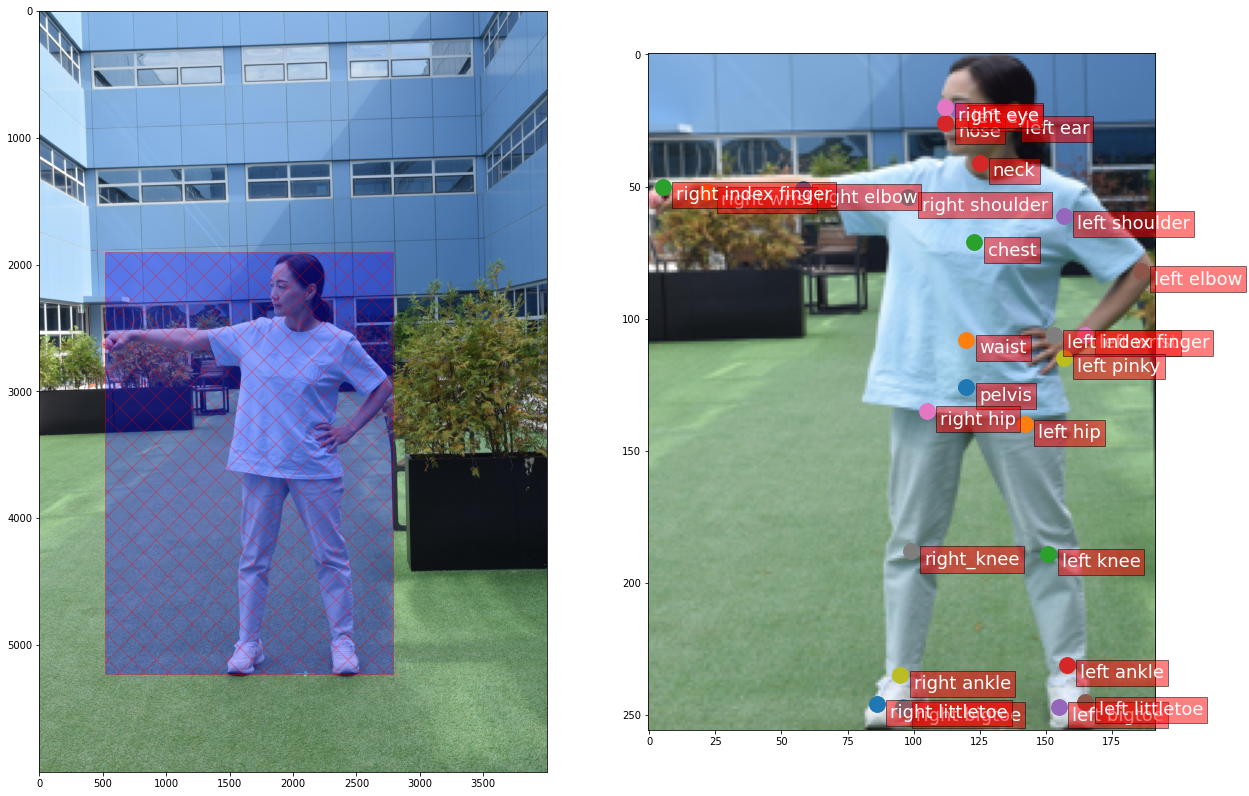

In [29]:
img_id,bbox,keypoints,k_vis = get_sample_att(99)
og_img = get_img(img_id)
bbox = check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img)
res_img = crop_resize_img(og_img,bbox)
keypoints = rescale_keypoints(keypoints,bbox)
display_images_keypoints(1,og_img,bbox,res_img,keypoints,k_vis)

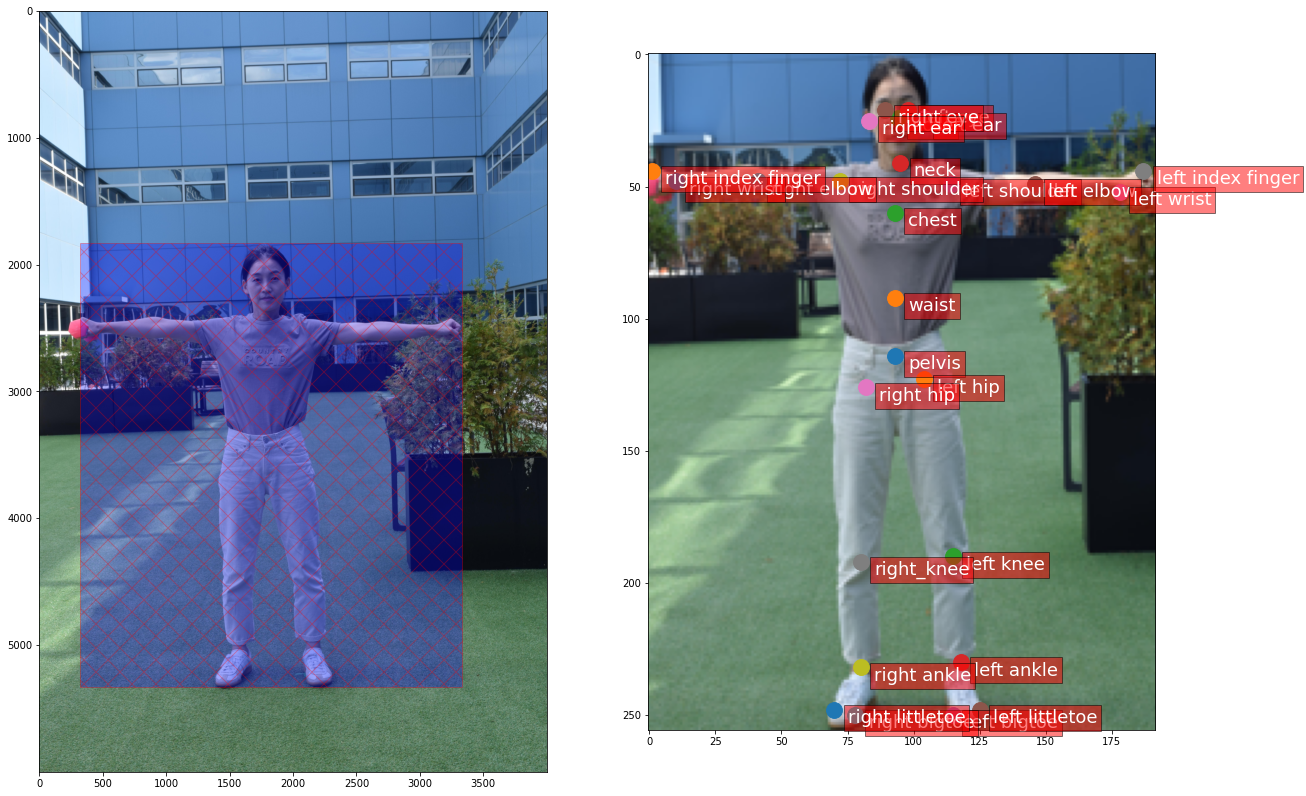

In [20]:
img_id,bbox,keypoints,k_vis = get_sample_att(130)
og_img = get_img(img_id)
bbox = check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img)
res_img = crop_resize_img(og_img,bbox)
keypoints = rescale_keypoints(keypoints,bbox)
display_images_keypoints(1,og_img,bbox,res_img,keypoints,k_vis)